In [1]:
# from google.colab import drive
# drive.mount('/content/drive/') # mount your google drive to access file

In [2]:
# change to the notebook directory
# MJF below
# %cd '/content/drive/MyDrive/OpALStar/FYP/opal/notebooks/'
# AMJ below
# %cd '/content/drive/MyDrive/Colab Notebooks/OpALStar/FYP/opal/notebooks/'


# Max Parameters
### These parameters optimize AUC over combination of complexity/env/time horizons

In [3]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import importlib
from sklearn import metrics
import pickle

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
# my models
import opal
from opal import OpAL
import learning
import plot_dynamics
from scipy.stats import beta as beta_rv

# data directory
path2 = "../standard_rl/"
sys.path.insert(1, os.path.join(sys.path[0], path2))
import rl
from rl import RL
import learn

# auc plotter
sys.path.insert(1, os.path.join(sys.path[0], '../../helpers/'))
import aucplotter

%matplotlib inline

In [4]:
# other paths
path_seeds = "../random_seeds/"
path_params = "../../model_cmp/filter_1.00/revisions2/all/"

In [5]:
k = 20
n_states = 10000
rho = 0.0
crit = "SA"

# generate new random seeds?
new_seeds = True

# reward mag and loss mag
# same for each
r_mag = 1
l_mag = 0
v0 = 0.5*r_mag + .5*l_mag

# magnitude
norm = True
mag = r_mag - l_mag

# anneal learning rate?
anneal = True
use_var = True
T = 10.0

# decay to prior?
decay_to_prior = False
decay_to_prior_gamma = 5

# pgrad?
pgrad = False

# only modify sufficiently above 50%
phi = 1.0

# ax labels
ax_labels_best = {"80": "80%", "30": "30%"}
ax_labels_worst = {"80": "70%", "30": "20%"}

In [6]:
ntrials = 250
complexity = 2
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]

## Parameter Summary

In [7]:
str_env = "rich" # rich, lean, or cross
print("HORIZON: %d \t COMPLEXITY: %d \t ENV: %s" %(ntrials,complexity,str_env))
for model in list(max_params.keys()):
    print(model + ":\t" + str(max_params[model][str_env]["params"][0]))

HORIZON: 250 	 COMPLEXITY: 2 	 ENV: rich
UCB:	0.43
RL:	(0.05, 18.0)
NoHebb:	(0.1, 0.4, 1.0)
SACrit_BayesAnneal:	(0.05, 1.0, 1.5)
SACrit_BayesAnneal_mod:	(0.1, 0.7, 3.5)


## Rich Env

In [8]:
# reproduce optimal learning curve
env = "80_10_%d" %(complexity)

if not new_seeds:
        rnd_seeds_OpAL = pickle.load(open("../random_seeds/OpAL/%s_rnd_seeds.pkle" %(env),"rb"))
        rnd_seeds_RL = pickle.load(open("../random_seeds/RL/%s_rnd_seeds.pkle" %(env),"rb"))
        rnd_seeds_UCB = pickle.load(open("../random_seeds/UCB/%s_rnd_seeds.pkle" %(env),"rb"))
else:
        new_seeds_please = np.random.randint(1,100000,n_states)
        rnd_seeds_OpAL = rnd_seeds_RL = rnd_seeds_UCB = new_seeds_please

# R_states_OpAL_plus = learning.simulate(max_params['SACrit_BayesAnneal']["cross"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="constant",k=k,norm=norm,    
#         mag=mag,rnd_seeds=rnd_seeds_OpAL,anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
#         decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
R_states_OpAL_Star = learning.simulate(max_params['SACrit_BayesAnneal_mod']["rich"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
# R_states_OpAL_NoHebb = learning.simulate(max_params['NoHebb']["cross"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
#         anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
#         decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad, 
#         hebb=False)
R_UCB = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=max_params['UCB']["rich"]["params"][0],rnd_seeds=rnd_seeds_UCB)
R_Q = learn.simulate(max_params['RL']["cross"]["params"][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)

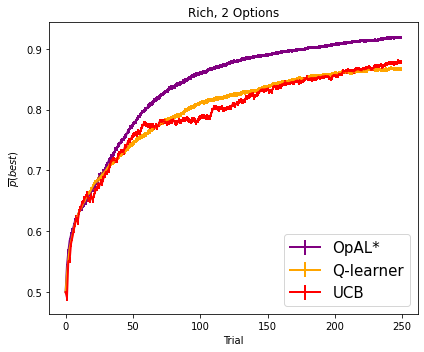

In [9]:
fig, axs = plt.subplots(figsize=(6, 5))
# plot_dynamics.avg_sm(R_states_OpAL_plus,ntrials,n_states,0,axs,"black")
plot_dynamics.avg_sm(R_states_OpAL_Star,ntrials,n_states,0,axs,"purple")
# plot_dynamics.avg_sm(R_states_OpAL_NoHebb,ntrials,n_states,0,axs,"blue")
plot_dynamics.avg_sm(R_Q,ntrials,n_states,0,axs,"orange")
plot_dynamics.avg_sm(R_UCB,ntrials,n_states,0,axs,"red")

plt.legend(("OpAL*","Q-learner","UCB"), fontsize = 15, markerscale = 50, loc = 'lower right')
# plt.legend(("$\\rho=0$", "$\\rho \propto V$", "NoHebb", "Q-learner","UCB"), fontsize = 15, markerscale = 50, loc = 'lower right')
plt.title("Rich, %d Options" %(complexity))
plt.xlabel("Trial")
plt.ylabel("$\overline{p}(best)$")
plt.tight_layout()
# plt.ylim([0.0,1.])

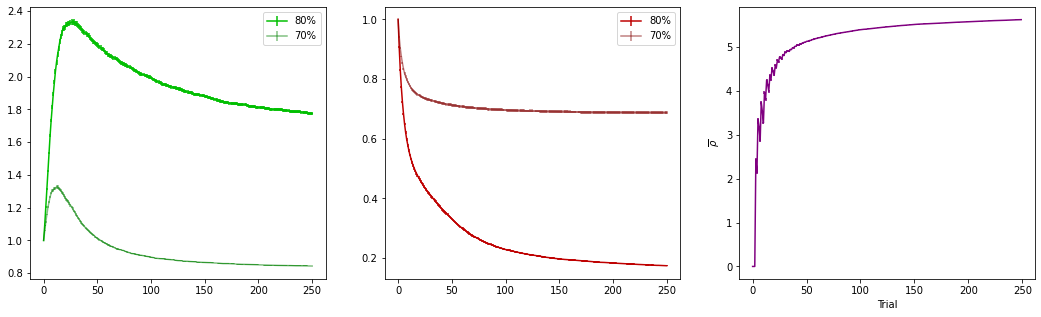

In [10]:
# Plot avg G/N/Pho curves
fig = plt.figure(figsize = (6*3,5))
gs = fig.add_gridspec(1,3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
env  = "80"
plot_me = R_states_OpAL_Star

axs = [ax1,ax2]
plot_dynamics.avg_qs(plot_me,ntrials,n_states,0,axs,.75)
for c in range(complexity-1):
    plot_dynamics.avg_qs(plot_me,ntrials,n_states,c+1,axs,.5,alpha=0.5)
get_leg = env[0:2]
ax1.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
ax2.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
plt.ylabel("$\overline{\\rho}$")
plt.xlabel("Trial")
plot_dynamics.avg_rho(plot_me,ntrials,n_states,ax3)

### Plot individual curves

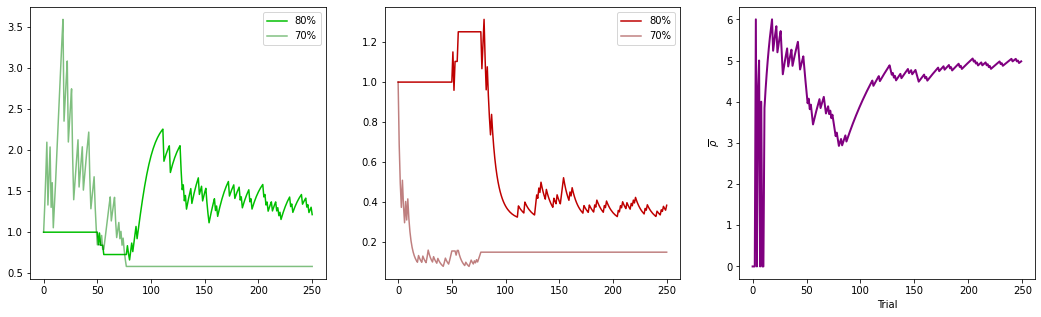

In [11]:
plot_me = R_states_OpAL_Star
how_many  = 1
env = "80_10"

for i in range(how_many):

    plot_me_only = [plot_me[i]]

    fig = plt.figure(figsize = (6*3,5))
    gs = fig.add_gridspec(1,3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    axs = [ax1,ax2]
    plot_dynamics.avg_qs(plot_me_only,ntrials,1,0,axs,.75) #n_states is now 1
    for c in range(complexity-1):
        plot_dynamics.avg_qs(plot_me_only,ntrials,1,c+1,axs,.5,alpha=0.5)
    get_leg = env[0:2]
    ax1.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
    ax2.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
    plt.ylabel("$\overline{\\rho}$")
    plt.xlabel("Trial")
    plot_dynamics.avg_rho(plot_me_only,ntrials,1,ax3)

## Lean Env

In [12]:
# reproduce optimal learning curve
env = "30_10_%d" %(complexity)
if not new_seeds:
        rnd_seeds_OpAL = pickle.load(open("../random_seeds/OpAL/%s_rnd_seeds.pkle" %(env),"rb"))
        rnd_seeds_RL = pickle.load(open("../random_seeds/RL/%s_rnd_seeds.pkle" %(env),"rb"))
        rnd_seeds_UCB = pickle.load(open("../random_seeds/UCB/%s_rnd_seeds.pkle" %(env),"rb"))
else:
        new_seeds_please = np.random.randint(1,100000,n_states)
        rnd_seeds_OpAL = rnd_seeds_RL = rnd_seeds_UCB = new_seeds_please

# L_states_OpAL_plus = learning.simulate(max_params['SACrit_BayesAnneal']["lean"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="constant",k=k,norm=norm,    
#         mag=mag,rnd_seeds=rnd_seeds_OpAL,anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
#         decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
L_states_OpAL_Star = learning.simulate(max_params['SACrit_BayesAnneal_mod']["lean"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
# L_states_OpAL_NoHebb = learning.simulate(max_params['NoHebb']["lean"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
#         anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
#         decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad, 
#         hebb=False)
L_UCB = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=max_params['UCB']["lean"]["params"][0],rnd_seeds=rnd_seeds_UCB)
L_Q = learn.simulate(max_params['RL']["lean"]["params"][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)

/Users/ajaskir/Desktop/FYP/opal/notebooks/../opal.py:144: RuntimeWarning: divide by zero encountered in log2
  self.H[idx] = -np.sum(ps*np.log2(ps))
/Users/ajaskir/Desktop/FYP/opal/notebooks/../opal.py:144: RuntimeWarning: invalid value encountered in multiply
  self.H[idx] = -np.sum(ps*np.log2(ps))


In [13]:
# # use optimizer values
# use_optimzer = True
# if use_optimzer:
#         if complexity == 2:
#                 if ntrials == 250:
#                         alphac,alphaa,beta,T_opt,phi_opt,K_opt = (0.09645833,  0.51111111,  1.00763889, 10.22222222,  1.02222222, 10.07638889)
#                         opt_params = (alphac,alphaa,beta)
#                 elif ntrials == 1000: 
#                         pass
#                 else:
#                         err = "horizon not supported"
#                         raise Exception(err)  
#         elif complexity == 6:
#                 if ntrials == 250:
#                         alphac,alphaa,beta,T_opt,phi_opt,K_opt = (0.09712705,  0.51520009,  1.02202429, 10.19867769,  0.98773228, 10.30400176)
#                         opt_params = (alphac,alphaa,beta)
#                 elif ntrials == 1000:
#                         pass 
#                 else:
#                         err = "horizon not supported"
#                         raise Exception(err) 
#         else:
#                 err = "complexity not supported"
#                 raise Exception(err)

#         L_states_OpAL_Star_OPT = learning.simulate(opt_params,n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=K_opt,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
#                 anneal=anneal,T=T_opt,use_var=use_var,phi=phi_opt,r_mag=r_mag,l_mag=l_mag,
#                 decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)

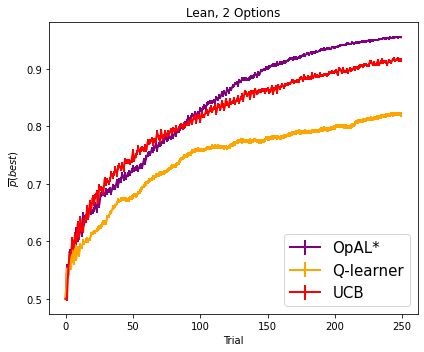

In [14]:
fig, axs = plt.subplots(figsize=(6, 5))
# plot_dynamics.avg_sm(L_states_OpAL_plus,ntrials,n_states,0,axs,"black")
plot_dynamics.avg_sm(L_states_OpAL_Star,ntrials,n_states,0,axs,"purple")
# plot_dynamics.avg_sm(L_states_OpAL_NoHebb,ntrials,n_states,0,axs,"blue")
plot_dynamics.avg_sm(L_Q,ntrials,n_states,0,axs,"orange")
plot_dynamics.avg_sm(L_UCB,ntrials,n_states,0,axs,"red")

plt.legend(("OpAL*","Q-learner","UCB"), fontsize = 15, markerscale = 50, loc = 'lower right')
# plt.legend(("$\\rho=0$", "$\\rho \propto V$", "NoHebb", "Q-learner","UCB"), fontsize = 15, markerscale = 50, loc = 'lower right')
plt.title("Lean, %d Options" %(complexity))
plt.xlabel("Trial")
plt.ylabel("$\overline{p}(best)$")
plt.tight_layout()
# plt.ylim([0.0,1.])

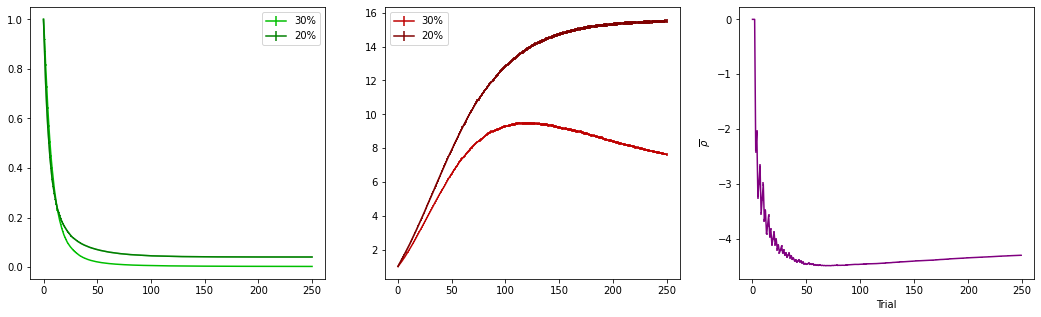

In [15]:
# Plot avg G/N/Pho curves
fig = plt.figure(figsize = (6*3,5))
gs = fig.add_gridspec(1,3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

plot_me = L_states_OpAL_Star
axs = [ax1,ax2]
plot_dynamics.avg_qs(plot_me,ntrials,n_states,0,axs,.75)
plot_dynamics.avg_qs(plot_me,ntrials,n_states,1,axs,.5)
for c in range(complexity-1):
    plot_dynamics.avg_qs(plot_me,ntrials,n_states,c+1,axs,.5,alpha=0.5)
get_leg = env[0:2]
ax1.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
ax2.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
plt.ylabel("$\overline{\\rho}$")
plt.xlabel("Trial")
plot_dynamics.avg_rho(plot_me,ntrials,n_states,ax3)

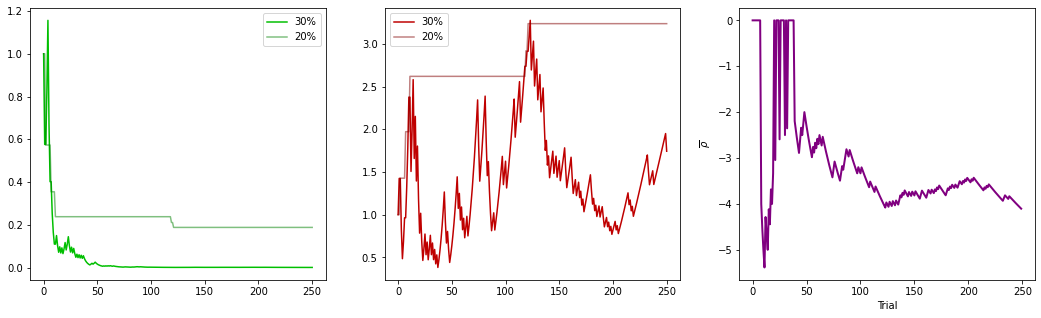

In [16]:
plot_me = L_states_OpAL_Star
how_many  = 1
env = "30_10"

for i in range(how_many):

    plot_me_only = [plot_me[i]]

    fig = plt.figure(figsize = (6*3,5))
    gs = fig.add_gridspec(1,3)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    axs = [ax1,ax2]
    plot_dynamics.avg_qs(plot_me_only,ntrials,1,0,axs,.75) #n_states is now 1
    for c in range(complexity-1):
        plot_dynamics.avg_qs(plot_me_only,ntrials,1,c+1,axs,.5,alpha=0.5)
    get_leg = env[0:2]
    ax1.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
    ax2.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
    plt.ylabel("$\overline{\\rho}$")
    plt.xlabel("Trial")
    plot_dynamics.avg_rho(plot_me_only,ntrials,1,ax3)

# Out of distribution

In [17]:
env = "80_10_10" 
base_env = "80_10_%d" %(complexity)
rnd_seeds_OpAL = pickle.load(open("../random_seeds/OpAL/%s_rnd_seeds.pkle" %(base_env),"rb"))
rnd_seeds_RL = pickle.load(open("../random_seeds/RL/%s_rnd_seeds.pkle" %(base_env),"rb"))
rnd_seeds_UCB = pickle.load(open("../random_seeds/UCB/%s_rnd_seeds.pkle" %(base_env),"rb"))

R_D_states_OpAL_plus = learning.simulate(max_params['SACrit_BayesAnneal']["cross"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="constant",k=k,norm=norm,    
        mag=mag,rnd_seeds=rnd_seeds_OpAL,anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
R_D_states_OpAL_Star = learning.simulate(max_params['SACrit_BayesAnneal_mod']["cross"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
R_D_states_OpAL_NoHebb = learning.simulate(max_params['NoHebb']["cross"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad, 
        hebb=False)
R_D_UCB = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=max_params['UCB']["cross"]["params"][0],rnd_seeds=rnd_seeds_UCB)
R_D_Q = learn.simulate(max_params['RL']["cross"]["params"][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)

IndexError: index 1000 is out of bounds for axis 0 with size 1000

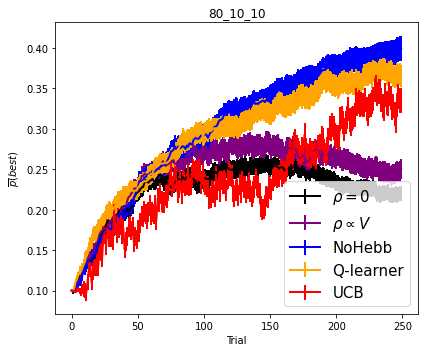

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))
plot_dynamics.avg_sm(R_D_states_OpAL_plus,ntrials,n_states,0,axs,"black")
plot_dynamics.avg_sm(R_D_states_OpAL_Star,ntrials,n_states,0,axs,"purple")
plot_dynamics.avg_sm(R_D_states_OpAL_NoHebb,ntrials,n_states,0,axs,"blue")
plot_dynamics.avg_sm(R_D_Q,ntrials,n_states,0,axs,"orange")
plot_dynamics.avg_sm(R_D_UCB,ntrials,n_states,0,axs,"red")

plt.legend(("$\\rho=0$", "$\\rho \propto V$", "NoHebb", "Q-learner","UCB"), fontsize = 15, markerscale = 50, loc = 'lower right')
plt.title("80_10_10")
plt.xlabel("Trial")
plt.ylabel("$\overline{p}(best)$")
plt.tight_layout()
# plt.ylim([0.5,1.])

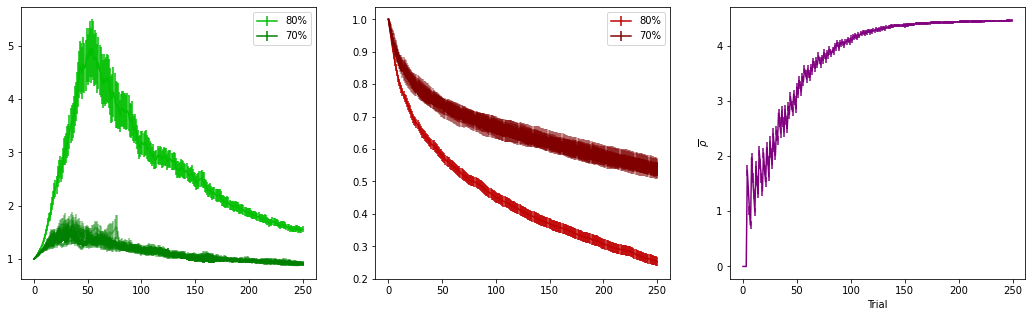

In [ ]:
# Plot avg G/N/Pho curves
fig = plt.figure(figsize = (6*3,5))
gs = fig.add_gridspec(1,3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
# env  = "80"
# ntrials = 250 

plot_me = R_D_states_OpAL_Star
axs = [ax1,ax2]
plot_dynamics.avg_qs(plot_me,ntrials,n_states,0,axs,.75)
plot_dynamics.avg_qs(plot_me,ntrials,n_states,1,axs,.5)
for c in range(9):
    plot_dynamics.avg_qs(plot_me,ntrials,n_states,c+1,axs,.5,alpha=0.5)
get_leg = env[0:2]
ax1.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
ax2.legend([ax_labels_best[get_leg], ax_labels_worst[get_leg]])
plt.ylabel("$\overline{\\rho}$")
plt.xlabel("Trial")
plot_dynamics.avg_rho(plot_me,ntrials,n_states,ax3)

In [ ]:
# reproduce optimal learning curve
env = "30_10_10" 
base_env = "30_10_%d" %(complexity)
rnd_seeds_OpAL = pickle.load(open("../random_seeds/OpAL/%s_rnd_seeds.pkle" %(base_env),"rb"))
rnd_seeds_RL = pickle.load(open("../random_seeds/RL/%s_rnd_seeds.pkle" %(base_env),"rb"))
rnd_seeds_UCB = pickle.load(open("../random_seeds/UCB/%s_rnd_seeds.pkle" %(base_env),"rb"))

L_D_states_OpAL_plus = learning.simulate(max_params['SACrit_BayesAnneal']["cross"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="constant",k=k,norm=norm,    
        mag=mag,rnd_seeds=rnd_seeds_OpAL,anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
L_D_states_OpAL_Star = learning.simulate(max_params['SACrit_BayesAnneal_mod']["cross"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad)
L_D_states_OpAL_NoHebb = learning.simulate(max_params['NoHebb']["cross"]["params"][0],n_states,ntrials,v0=v0,crit=crit,env=env,mod="beta",k=k,norm=norm,mag=mag,rnd_seeds=rnd_seeds_OpAL,\
        anneal=anneal,T=T,use_var=use_var,phi=phi,r_mag=r_mag,l_mag=l_mag,
        decay_to_prior = decay_to_prior, decay_to_prior_gamma = decay_to_prior_gamma,pgrad = pgrad, 
        hebb=False)
L_D_UCB = learn.simulate(np.array([0.,0.]),n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=True, UCB_samplemean=True, gamma=max_params['UCB']["cross"]["params"][0],rnd_seeds=rnd_seeds_UCB)
L_D_Q = learn.simulate(max_params['RL']["cross"]["params"][0],n_states,ntrials,v0=v0,env=env,r_mag=1,l_mag=0, UCB=False, UCB_samplemean=False,rnd_seeds=rnd_seeds_RL)

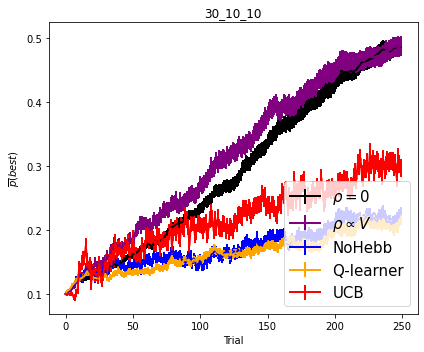

In [ ]:
fig, axs = plt.subplots(figsize=(6, 5))
plot_dynamics.avg_sm(L_D_states_OpAL_plus,ntrials,n_states,0,axs,"black")
plot_dynamics.avg_sm(L_D_states_OpAL_Star,ntrials,n_states,0,axs,"purple")
plot_dynamics.avg_sm(L_D_states_OpAL_NoHebb,ntrials,n_states,0,axs,"blue")
plot_dynamics.avg_sm(L_D_Q,ntrials,n_states,0,axs,"orange")
plot_dynamics.avg_sm(L_D_UCB,ntrials,n_states,0,axs,"red")

plt.legend(("$\\rho=0$", "$\\rho \propto V$", "NoHebb", "Q-learner","UCB"), fontsize = 15, markerscale = 50, loc = 'lower right')
plt.title("30_10_10")
plt.xlabel("Trial")
plt.ylabel("$\overline{p}(best)$")
plt.tight_layout()
# plt.ylim([0.5,1.])

# UCB parameter graphs

In [ ]:
# other paths
path_seeds = "../random_seeds/"
path_params = "../../model_cmp/filter_1.00/revisions2/all/" 

In [ ]:
ntrials = 250
complexity = 2
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/auc_order.pkle" %(ntrials)
auc_orders = pickle.load(open(full_param_path,"rb")) # parameters order by AUCS across environment, keys: 'UCB', 'SACrit_BayesAnneal', 'SACrit_BayesAnneal_mod', 'RL', 'NoHebb', 'Bmod'

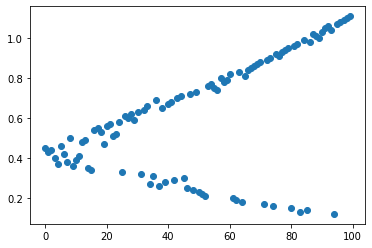

In [ ]:
# top 10 parameters
complexity = 2
str_complexity = str(complexity)
pltme = auc_orders[str_complexity]['UCB'][0:100]
xaxis = np.arange(0,len(pltme))
plt.scatter(xaxis,pltme)

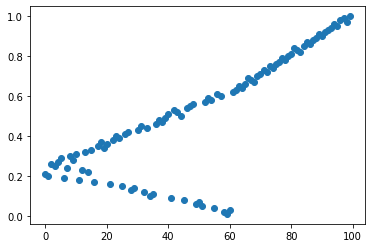

In [ ]:
# top 10 parameters
complexity = 6
str_complexity = str(complexity)
pltme = auc_orders[str_complexity]['UCB'][0:100]
xaxis = np.arange(0,len(pltme))
plt.scatter(xaxis,pltme)

In [ ]:
ntrials = 1000
full_param_path = path_params + "trials0_%d/auc_order.pkle" %(ntrials)
auc_orders = pickle.load(open(full_param_path,"rb")) # parameters order by AUCS across environment, keys: 'UCB', 'SACrit_BayesAnneal', 'SACrit_BayesAnneal_mod', 'RL', 'NoHebb', 'Bmod'

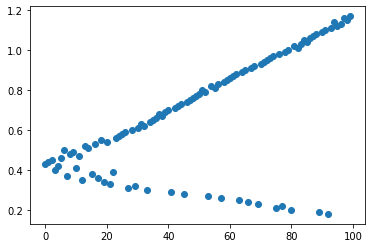

In [ ]:
# top 10 parameters
complexity = 2
str_complexity = str(complexity)
pltme = auc_orders[str_complexity]['UCB'][0:100]
xaxis = np.arange(0,len(pltme))
plt.scatter(xaxis,pltme)

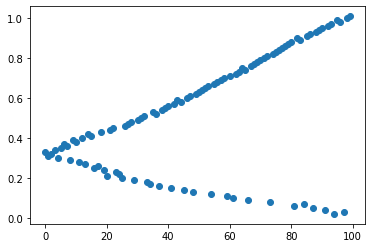

In [ ]:
# top 10 parameters
complexity = 6
str_complexity = str(complexity)
pltme = auc_orders[str_complexity]['UCB'][0:100]
xaxis = np.arange(0,len(pltme))
plt.scatter(xaxis,pltme)

# UCB parameter sensitivity

In [ ]:
ntrials = 250
complexity = 2
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]
top_aucs_rich_250_2 = max_params["UCB"]["rich"]["AUCs"][0:100]
top_params_rich_250_2 = max_params["UCB"]["rich"]["params"][0:100]
top_aucs_lean_250_2 = max_params["UCB"]["lean"]["AUCs"][0:100]
top_params_lean_250_2 = max_params["UCB"]["lean"]["params"][0:100]

In [ ]:
ntrials = 250
complexity = 6
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]
top_aucs_rich_250_6 = max_params["UCB"]["rich"]["AUCs"][0:100]
top_params_rich_250_6 = max_params["UCB"]["rich"]["params"][0:100]
top_aucs_lean_250_6 = max_params["UCB"]["lean"]["AUCs"][0:100]
top_params_lean_250_6 = max_params["UCB"]["lean"]["params"][0:100]

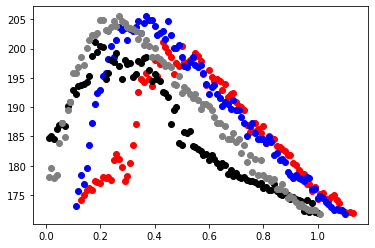

In [ ]:
plt.scatter(top_params_rich_250_2,top_aucs_rich_250_2,c="red")
plt.scatter(top_params_lean_250_2,top_aucs_lean_250_2,c="blue")
plt.scatter(top_params_rich_250_6,top_aucs_rich_250_2,c="black")
plt.scatter(top_params_lean_250_6,top_aucs_lean_250_2,c="grey")

In [ ]:
ntrials = 1000
complexity = 2
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]
top_aucs_rich_1000_2 = max_params["UCB"]["rich"]["AUCs"][0:100]
top_params_rich_1000_2 = max_params["UCB"]["rich"]["params"][0:100]
top_aucs_lean_1000_2 = max_params["UCB"]["lean"]["AUCs"][0:100]
top_params_lean_1000_2 = max_params["UCB"]["lean"]["params"][0:100]

In [ ]:
ntrials = 1000
complexity = 6
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]
top_aucs_rich_1000_6 = max_params["UCB"]["rich"]["AUCs"][0:100]
top_params_rich_1000_6 = max_params["UCB"]["rich"]["params"][0:100]
top_aucs_lean_1000_6 = max_params["UCB"]["lean"]["AUCs"][0:100]
top_params_lean_1000_6 = max_params["UCB"]["lean"]["params"][0:100]

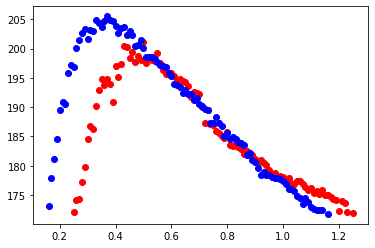

In [ ]:
plt.scatter(top_params_rich_1000_2,top_aucs_rich_250_2,c="red")
plt.scatter(top_params_lean_1000_2,top_aucs_lean_250_2,c="blue")

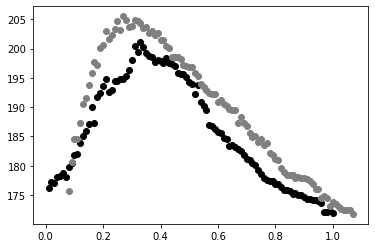

In [ ]:
plt.scatter(top_params_rich_1000_6,top_aucs_rich_250_2,c="black")
plt.scatter(top_params_lean_1000_6,top_aucs_lean_250_2,c="grey")

In [ ]:
ntrials = 250
complexity = 2
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]
top_aucs_cross_250_2 = max_params["UCB"]["cross"]["AUCs"][0:100]
top_params_cross_250_2 = max_params["UCB"]["cross"]["params"][0:100]

ntrials = 250
complexity = 6
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]
top_aucs_cross_250_6 = max_params["UCB"]["cross"]["AUCs"][0:100]
top_params_cross_250_6 = max_params["UCB"]["cross"]["params"][0:100]

ntrials = 1000
complexity = 2
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]
top_aucs_cross_1000_2 = max_params["UCB"]["cross"]["AUCs"][0:100]
top_params_cross_1000_2 = max_params["UCB"]["cross"]["params"][0:100]

ntrials = 1000
complexity = 6
str_complexity = str(complexity)
full_param_path = path_params + "trials0_%d/max_param_complexity%d.pkle" %(ntrials,complexity) 
max_params = pickle.load(open(full_param_path,"rb")) # max_params[model][env][AUCs or params], where env = [rich, lean]
top_aucs_cross_1000_6 = max_params["UCB"]["cross"]["AUCs"][0:100]
top_params_cross_1000_6 = max_params["UCB"]["cross"]["params"][0:100]

Text(0.5, 1.0, 'UCB cross-environment performance - 250 trials')

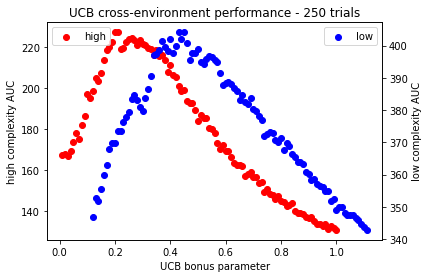

In [ ]:
fig,ax = plt.subplots()

ax.scatter(top_params_cross_250_6,top_aucs_cross_250_6,c="red")
ax.set_ylabel("high complexity AUC")
ax.legend(["high"],loc="upper left")
ax2 = ax.twinx()
ax2.scatter(top_params_cross_250_2,top_aucs_cross_250_2,c="blue")
ax2.legend(["low"],loc="upper right")
ax2.set_ylabel("low complexity AUC")
ax.set_xlabel("UCB bonus parameter")
ax.set_title("UCB cross-environment performance - 250 trials")

Text(0.5, 1.0, 'UCB cross-environment performance - 1000 trials')

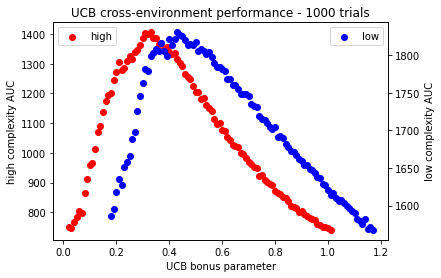

In [ ]:
fig,ax = plt.subplots()

ax.scatter(top_params_cross_1000_6,top_aucs_cross_1000_6,c="red")
ax.set_ylabel("high complexity AUC")
ax.legend(["high"],loc="upper left")
ax2 = ax.twinx()
ax2.scatter(top_params_cross_1000_2,top_aucs_cross_1000_2,c="blue")
ax2.legend(["low"],loc="upper right")
ax2.set_ylabel("low complexity AUC")
ax.set_xlabel("UCB bonus parameter")
ax.set_title("UCB cross-environment performance - 1000 trials")